In [1]:
!pip install -U openai-whisper jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: rapidfuzz
    Found existing installation: rapidfuzz 3.9.3
    Uninstalling rapidfuzz-3.9.3:
      Successfully uninstalled rapidfuzz-3.9.3
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
  Attempting uninstall: jiwerm╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [click]
    Found existing installation: jiwer 3.0.4━━━━━━━━━━━━━━━━━━ 1/3 [click]
    Uninstalling jiwer-3.0.4:0m━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [click]
      Successfully uninstalled jiwer-3.0.4━━━━━━━━━━━━━━━━━━━━ 1/3 [click]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [jiwer]/3 [click]


In [2]:
import whisper
import torch
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import numpy as np
from IPython.display import Audio, display
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from matplotlib.patches import Rectangle
from torchaudio.utils import download_asset
import librosa
import matplotlib.pyplot as plt
import glob
import os
from jiwer import wer
from tqdm import tqdm
import pandas as pd


In [3]:
WHISPER_MODEL = "base"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLE_RATE = 16000
CUTOFF = 15000  # For embed attack
TINY_SNIPPET_LENGTH = 50  # Defense snippet length

print(f"Using device: {DEVICE}")

# Load Whisper model
model = whisper.load_model(WHISPER_MODEL).to(DEVICE)
print(f"Loaded Whisper {WHISPER_MODEL} model")


Using device: cpu


100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 49.3MiB/s]


Loaded Whisper base model


In [4]:
# prepend_attack_path = r"C:\Users\judoc\Documents\GitHub\TTPure\base.np.npy"
prepend_attack_path = "/Users/alectandoc/Documents/GitHub/TTPure/base.np.npy"
# embed_attack_path = "C:/Users/judoc/Documents/GitHub/TTPure/tucker_attacks/trained_univ_embed_seg.th"
# embed_attack_path = r"C:\Users\judoc\Documents\GitHub\TTPure\tucker_attacks\1k_saved_segments\prepend_attack_models\epoch15\model.th"
embed_attack_path = "/Users/alectandoc/Documents/GitHub/TTPure/0_30k_cutoff.th"

try:
    # Load prepend attack
    univ_attack_seg_prepend_arr = np.load(prepend_attack_path)
    univ_attack_seg_prepend = torch.from_numpy(univ_attack_seg_prepend_arr).to(DEVICE)
    print(f"Loaded prepend attack segment: shape {univ_attack_seg_prepend.shape}")
except:
    print("Warning: Could not load prepend attack file. Using random noise for demonstration.")
    # Create dummy attack for testing if file not found
    univ_attack_seg_prepend = torch.randn(16000).to(DEVICE) * 0.01

try:
    # Load embed attack
    embed_data = torch.load(embed_attack_path, map_location=torch.device(DEVICE))
    appended_noise = embed_data["audio_attack_segment"]
    print(f"Loaded embed attack segment: shape {appended_noise.shape}")
except:
    print("Warning: Could not load embed attack file. Using random noise for demonstration.")
    # Create dummy attack for testing if file not found
    appended_noise = torch.randn(8000).to(DEVICE) * 0.01


Loaded prepend attack segment: shape torch.Size([10240])
Loaded embed attack segment: shape torch.Size([10240])


In [5]:
# base_dir = r"C:/Users/judoc/Documents/GitHub/TTPure/tucker_attacks/data/test-clean"
base_dir = "/Users/alectandoc/Documents/GitHub/TTPure/tucker_attacks/LibriSpeech"
flac_files = glob.glob(os.path.join(base_dir, "**", "**", "*.flac"), recursive=True)

# Limit to 200 files for testing
training_data_size = 200
data = [{"audio": path} for path in flac_files[:training_data_size]]

print(f"Found {len(flac_files)} FLAC files total")
print(f"Using {len(data)} files for testing")

Found 10480 FLAC files total
Using 200 files for testing


In [6]:
def load_audio(audio_path, sr=SAMPLE_RATE):
    """Load audio file and resample to target sample rate"""
    audio, orig_sr = torchaudio.load(audio_path)
    if orig_sr != sr:
        resampler = T.Resample(orig_sr, sr)
        audio = resampler(audio)
    # Convert to mono if stereo
    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)
    return audio.squeeze().to(DEVICE)

def calculate_wer(reference, hypothesis):
    """Calculate Word Error Rate between reference and hypothesis"""
    if not reference or not hypothesis:
        return 1.0  # 100% error if either is empty
    return wer(reference.lower().strip(), hypothesis.lower().strip())

def categorize_wer(wer_value):
    """Categorize WER into buckets"""
    if wer_value >= 1.0:  # 100% WER (complete muting)
        return "100% WER (Muted)"
    elif wer_value > 0.30:  # > 30.0% WER
        return "> 30.0% WER"
    else:  # <= 30.0% WER
        return "<= 30.0% WER"

In [7]:
def apply_prepend_attack(audio, attack_segment):
    """Apply prepend attack by concatenating attack segment before audio"""
    return torch.cat((attack_segment, audio), dim=0)

def defend_prepend_attack(attacked_audio, defense_snippet):
    """Defend against prepend attack by adding a tiny snippet at the beginning"""
    return torch.cat((defense_snippet, attacked_audio), dim=0)

def apply_embed_attack(audio, attack_segment, cutoff=CUTOFF):
    """Apply embed attack by inserting attack segment at cutoff position"""
    if len(audio) <= cutoff:
        # If audio is shorter than cutoff, append at the end
        return torch.cat((audio, attack_segment), dim=0)
    return torch.cat((audio[:cutoff], attack_segment, audio[cutoff:]), dim=0)

def defend_embed_attack(attacked_audio, defense_snippet):
    """Defend against embed attack by prepending a tiny snippet"""
    return torch.cat((defense_snippet, attacked_audio), dim=0)

In [8]:
results = {
    "file": [],
    "benign_transcription": [],
    "benign_wer": [],
    
    "prepend_transcription": [],
    "prepend_wer": [],
    "prepend_relative_wer": [],
    "prepend_category": [],
    
    "prepend_defended_transcription": [],
    "prepend_defended_wer": [],
    "prepend_defended_relative_wer": [],
    "prepend_defended_category": [],
    
    "embed_transcription": [],
    "embed_wer": [],
    "embed_relative_wer": [],
    "embed_category": [],
    
    "embed_defended_transcription": [],
    "embed_defended_wer": [],
    "embed_defended_relative_wer": [],
    "embed_defended_category": []
}

# Process each audio file
for i, item in enumerate(tqdm(data, desc="Processing audio files")):
    audio_path = item["audio"]
    
    try:
        # Load audio
        audio = load_audio(audio_path)
        
        # Get ground truth transcription (benign)
        benign_result = model.transcribe(audio.cpu().numpy())
        benign_transcription = benign_result["text"]
        
        # Create defense snippet (first 50 frames)
        defense_snippet = audio[:TINY_SNIPPET_LENGTH]
        
        # Store file info
        results["file"].append(os.path.basename(audio_path))
        results["benign_transcription"].append(benign_transcription)
        results["benign_wer"].append(0.0)  # Reference WER is 0
        
        # Test 1: Prepend Attack
        prepend_attacked = apply_prepend_attack(audio, univ_attack_seg_prepend)
        prepend_result = model.transcribe(prepend_attacked.cpu().numpy())
        prepend_transcription = prepend_result["text"]
        prepend_wer = calculate_wer(benign_transcription, prepend_transcription)
        
        results["prepend_transcription"].append(prepend_transcription)
        results["prepend_wer"].append(prepend_wer)
        results["prepend_relative_wer"].append(prepend_wer)  # Relative to benign (0% WER)
        results["prepend_category"].append(categorize_wer(prepend_wer))
        
        # Test 2: Prepend Attack + Defense
        prepend_defended = defend_prepend_attack(prepend_attacked, defense_snippet)
        prepend_defended_result = model.transcribe(prepend_defended.cpu().numpy())
        prepend_defended_transcription = prepend_defended_result["text"]
        prepend_defended_wer = calculate_wer(benign_transcription, prepend_defended_transcription)
        
        results["prepend_defended_transcription"].append(prepend_defended_transcription)
        results["prepend_defended_wer"].append(prepend_defended_wer)
        results["prepend_defended_relative_wer"].append(prepend_defended_wer)
        results["prepend_defended_category"].append(categorize_wer(prepend_defended_wer))
        
        # Test 3: Embed Attack
        embed_attacked = apply_embed_attack(audio, appended_noise, CUTOFF)
        embed_result = model.transcribe(embed_attacked.cpu().numpy())
        embed_transcription = embed_result["text"]
        embed_wer = calculate_wer(benign_transcription, embed_transcription)
        
        results["embed_transcription"].append(embed_transcription)
        results["embed_wer"].append(embed_wer)
        results["embed_relative_wer"].append(embed_wer)
        results["embed_category"].append(categorize_wer(embed_wer))
        
        # Test 4: Embed Attack + Defense
        embed_defended = defend_embed_attack(embed_attacked, defense_snippet)
        embed_defended_result = model.transcribe(embed_defended.cpu().numpy())
        embed_defended_transcription = embed_defended_result["text"]
        embed_defended_wer = calculate_wer(benign_transcription, embed_defended_transcription)
        
        results["embed_defended_transcription"].append(embed_defended_transcription)
        results["embed_defended_wer"].append(embed_defended_wer)
        results["embed_defended_relative_wer"].append(embed_defended_wer)
        results["embed_defended_category"].append(categorize_wer(embed_defended_wer))
        
    except Exception as e:
        print(f"Error processing {audio_path}: {str(e)}")
        # Add None values for failed files
        for key in results:
            if key != "file":
                results[key].append(None)

# Create DataFrame
df_results = pd.DataFrame(results)
print(f"\nProcessed {len(df_results)} files successfully")

Processing audio files:   0%|          | 0/200 [00:00<?, ?it/s]/Users/alectandoc/opt/anaconda3/envs/env_py310/lib/python3.10/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")
Processing audio files:  40%|████      | 80/200 [12:01<18:02,  9.02s/it]


KeyboardInterrupt: 

In [ ]:
# Calculate statistics
print("\n=== ATTACK EFFECTIVENESS SUMMARY ===")
print(f"\nPrepend Attack:")
print(f"Average WER: {df_results['prepend_wer'].mean():.2%}")
print(f"Files with 100% WER: {(df_results['prepend_wer'] >= 1.0).sum()}")

print(f"\nPrepend Attack + Defense:")
print(f"Average WER: {df_results['prepend_defended_wer'].mean():.2%}")
print(f"Files with 100% WER: {(df_results['prepend_defended_wer'] >= 1.0).sum()}")

print(f"\nEmbed Attack:")
print(f"Average WER: {df_results['embed_wer'].mean():.2%}")
print(f"Files with 100% WER: {(df_results['embed_wer'] >= 1.0).sum()}")

print(f"\nEmbed Attack + Defense:")
print(f"Average WER: {df_results['embed_defended_wer'].mean():.2%}")
print(f"Files with 100% WER: {(df_results['embed_defended_wer'] >= 1.0).sum()}")



=== ATTACK EFFECTIVENESS SUMMARY ===

Prepend Attack:
Average WER: 100.00%
Files with 100% WER: 200

Prepend Attack + Defense:
Average WER: 53.16%
Files with 100% WER: 72

Embed Attack:
Average WER: 100.00%
Files with 100% WER: 200

Embed Attack + Defense:
Average WER: 74.43%
Files with 100% WER: 112


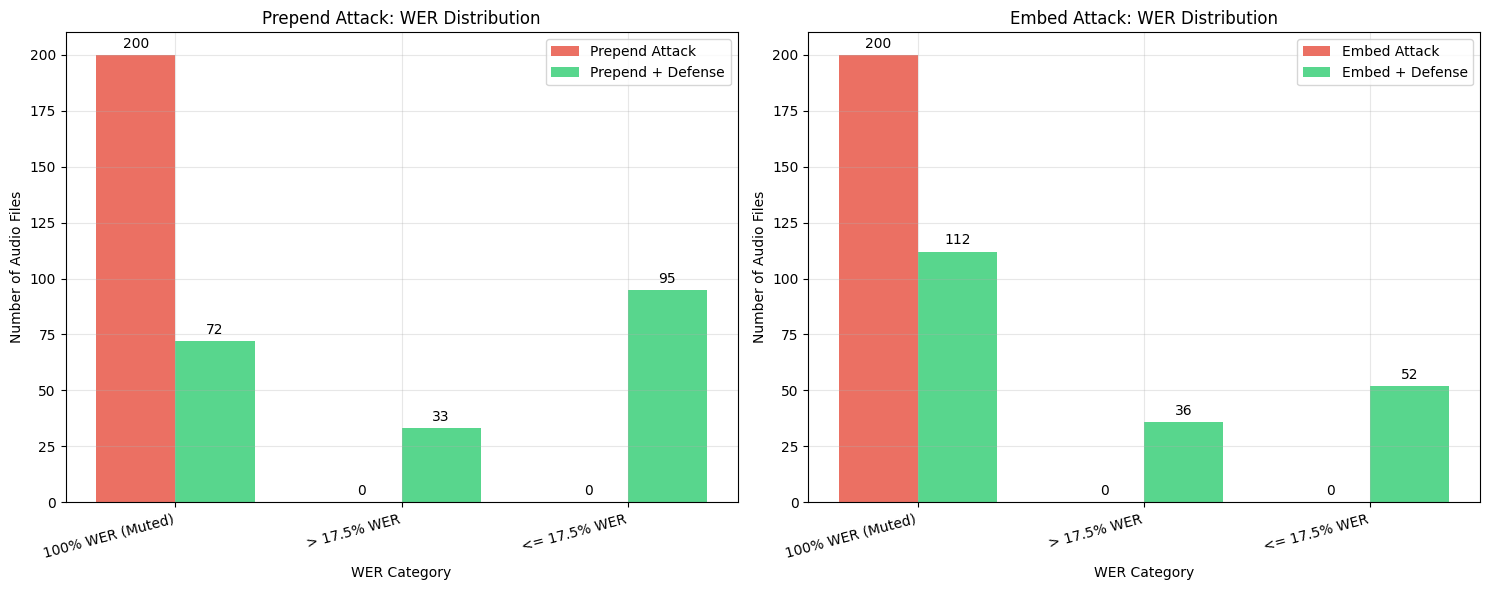

In [ ]:
# Prepare data for plotting
categories = ["100% WER (Muted)", "> 30.0% WER", "<= 30.0% WER"]
1
# Count occurrences for each category
prepend_counts = df_results['prepend_category'].value_counts()
prepend_defended_counts = df_results['prepend_defended_category'].value_counts()
embed_counts = df_results['embed_category'].value_counts()
embed_defended_counts = df_results['embed_defended_category'].value_counts()

# Ensure all categories are represented
for cat in categories:
    if cat not in prepend_counts:
        prepend_counts[cat] = 0
    if cat not in prepend_defended_counts:
        prepend_defended_counts[cat] = 0
    if cat not in embed_counts:
        embed_counts[cat] = 0
    if cat not in embed_defended_counts:
        embed_defended_counts[cat] = 0

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Prepend Attack
x = np.arange(len(categories))
width = 0.35

prepend_values = [prepend_counts[cat] for cat in categories]
prepend_defended_values = [prepend_defended_counts[cat] for cat in categories]

bars1 = ax1.bar(x - width/2, prepend_values, width, label='Prepend Attack', color='#e74c3c', alpha=0.8)
bars2 = ax1.bar(x + width/2, prepend_defended_values, width, label='Prepend + Defense', color='#2ecc71', alpha=0.8)

ax1.set_xlabel('WER Category')
ax1.set_ylabel('Number of Audio Files')
ax1.set_title('Prepend Attack: WER Distribution')
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation=15, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Plot 2: Embed Attack
embed_values = [embed_counts[cat] for cat in categories]
embed_defended_values = [embed_defended_counts[cat] for cat in categories]

bars3 = ax2.bar(x - width/2, embed_values, width, label='Embed Attack', color='#e74c3c', alpha=0.8)
bars4 = ax2.bar(x + width/2, embed_defended_values, width, label='Embed + Defense', color='#2ecc71', alpha=0.8)

ax2.set_xlabel('WER Category')
ax2.set_ylabel('Number of Audio Files')
ax2.set_title('Embed Attack: WER Distribution')
ax2.set_xticks(x)
ax2.set_xticklabels(categories, rotation=15, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Create summary table
summary_data = {
    'Attack Type': ['Prepend', 'Prepend + Defense', 'Embed', 'Embed + Defense'],
    '100% WER (Muted)': [
        prepend_counts["100% WER (Muted)"],
        prepend_defended_counts["100% WER (Muted)"],
        embed_counts["100% WER (Muted)"],
        embed_defended_counts["100% WER (Muted)"]
    ],
    '> 30.0% WER': [
        prepend_counts["> 30.0% WER"],
        prepend_defended_counts["> 30.0% WER"],
        embed_counts["> 30.0% WER"],
        embed_defended_counts["> 30.0% WER"]
    ],
    '<= 30.0% WER': [
        prepend_counts["<= 30.0% WER"],
        prepend_defended_counts["<= 30.0% WER"],
        embed_counts["<= 30.0% WER"],
        embed_defended_counts["<= 30.0% WER"]
    ],
    'Average WER': [
        f"{df_results['prepend_wer'].mean():.2%}",
        f"{df_results['prepend_defended_wer'].mean():.2%}",
        f"{df_results['embed_wer'].mean():.2%}",
        f"{df_results['embed_defended_wer'].mean():.2%}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n=== SUMMARY TABLE ===")
print(summary_df.to_string(index=False))


=== SUMMARY TABLE ===
      Attack Type  100% WER (Muted)  > 17.5% WER  <= 17.5% WER Average WER
          Prepend               200            0             0     100.00%
Prepend + Defense                72           33            95      53.16%
            Embed               200            0             0     100.00%
  Embed + Defense               112           36            52      74.43%


In [ ]:
# Save detailed results to CSV
output_path = "whisper_attack_results.csv"
df_results.to_csv(output_path, index=False)
print(f"\nDetailed results saved to: {output_path}")

# Save summary to CSV
summary_path = "whisper_attack_summary.csv"
summary_df.to_csv(summary_path, index=False)
print(f"Summary results saved to: {summary_path}")


Detailed results saved to: whisper_attack_results.csv
Summary results saved to: whisper_attack_summary.csv


In [ ]:
# Show some example transcriptions
print("\n=== EXAMPLE TRANSCRIPTIONS ===")
for i in range(min(3, len(df_results))):
    print(f"\nFile {i+1}: {df_results.iloc[i]['file']}")
    print(f"Benign: {df_results.iloc[i]['benign_transcription']}")
    print(f"Prepend Attack: {df_results.iloc[i]['prepend_transcription']}")
    print(f"Prepend Defended: {df_results.iloc[i]['prepend_defended_transcription']}")
    print(f"Embed Attack: {df_results.iloc[i]['embed_transcription']}")
    print(f"Embed Defended: {df_results.iloc[i]['embed_defended_transcription']}")
    print("-" * 80)


=== EXAMPLE TRANSCRIPTIONS ===

File 1: 1089-134686-0000.flac
Benign:  He hoped there would be stew for dinner, turnips and carrots and bruised potatoes and fat mutton pieces to be ladled out in thick, peppered flour-fatten sauce.
Prepend Attack: 
Prepend Defended: 
Embed Attack: 
Embed Defended: 
--------------------------------------------------------------------------------

File 2: 1089-134686-0001.flac
Benign:  Stuffed into you, his belly countled him.
Prepend Attack: 
Prepend Defended:  be sure to let your guide review this year instead of just letting out above that you will be... being nova and being irreversible é aur reflected on 2020 from today is awaiting for his media to come if it constructive
Embed Attack: 
Embed Defended:  Stuff it in. Video went to you. His belly counseled him.
--------------------------------------------------------------------------------

File 3: 1089-134686-0002.flac
Benign:  After early nightfall, the yellow lamps would light up here and there, t